
```{image} ../images/forecast.png
:width: 350px
:align: center
```

# Modelos numéricos de pronóstico

---

## Introducción
En este cuadernillo (Notebook) aprenderemos:

1. Introducción al GFS
4. Uso del servidor Thredds
1. Consulta de datos del GFS a escala de 0.5 grados en resolución usando `siphon`
2. Visualización de variables pronosticadas

## Prerequisitos
| Conceptos | Importancia | Notas |
| --- | --- | --- |
| [Introducción a Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necesario | Lectura de datos multidimensionales |
| [Introducción a Datetime](https://foundations.projectpythia.org/core/datetime/datetime.html) | Necesario | Entender estampas de tiempo |
| [Introducción a  NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Útil | Entender la metadata de los datos |

- **Tiempo de aprendizaje**: 30 minutos

---

## Librerías

Importamos las librerías que vamos a utilizar en este cuadernillo.

In [1]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from pandas import to_datetime
from siphon.catalog import TDSCatalog

## 1. GFS

De acuerdo con la documentación [oficial](https://www.emc.ncep.noaa.gov/emc/pages/numerical_forecast_systems/gfs.php) *"El Sistema de Pronóstico Global (GFS) es un modelo de pronóstico del tiempo de los Centros Nacionales de Predicción Ambiental (NCEP) que genera datos para docenas de variables atmosféricas y de suelo-suelo, incluidas temperaturas, vientos, precipitaciones, humedad del suelo y concentración de ozono atmosférico."*

```{figure} ../images/GFS - 20120712_0000-small.gif
:name: gfs-gif
:alt: Global Forecast System
:figclass: align-center
:width: 450px
*GFS Total Ozone*. Fuente: [NCEI](https://www.ncei.noaa.gov/)
```

* Sistema de Pronóstico Global
* Utilizado comunmente como condiciones iniciales para otros modelos de pronóstico
* El modelo se ejecuta 4 veces al día (00z, 06z, 12z y 18z)
* Prósticos de hasta 16 días. 120 primeras horas son a escala horaria, luego cada 3 horas
* Modelo tiene 127 capas en la vertical
* Utiliza un esquema de esfera cúbica de volumen finito [(FV3)](https://www.gfdl.noaa.gov/fv3/fv3-grids/)
* Resolución/dominio horizontal de 0.5, 1.0 y 2.5 grados

## 2. Acceso a datos del GFS

El acceso a los datos del GFS se puede realizar mediante la descarga directa de los datos utilizando el repositorio de datos del [NCEI](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00631/html) (*National Centers for Environmental Information*), usando el repositorio de datos de [AWS](https://registry.opendata.aws/noaa-gfs-bdp-pds/), o usando el servidor [Thredds](https://thredds-jumbo.unidata.ucar.edu/thredds/catalog/catalog.html) de la [NCAR](https://ncar.ucar.edu/). Para efectos prácticos del curso, utilizaremos la librería [siphon](https://unidata.github.io/siphon/latest/index.html) que nos permite realizar consultas al servidor `Thredds` usando una API en `Python`. 

Para consultar el modelo GFS con resolución espacial de 0.25 grados utilizamos el módulo `TDSCatalog` y pasamos el link correspondiente que se puede obtener [acá](https://thredds-jumbo.unidata.ucar.edu/thredds/catalog/catalog.html).

In [2]:
gfs_url = "http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best"
best_gfs = TDSCatalog(gfs_url)
best_gfs

Best GFS Quarter Degree Forecast Time Series

Para acceder a este conjunto de datos usando `Xarray.Dataset` simplemente creamos un acceso remoto de la siguiente manera

In [3]:
ds_gfs = best_gfs.datasets[0].remote_access(use_xarray=True)
print(f"size: {ds_gfs.nbytes / (1024 ** 3)} GB")
display(ds_gfs)

size: 519.7476559728384 GB


<xarray.Dataset> Size: 558GB
Dimensions:                                                                     (
                                                                                 time2: 332,
                                                                                 : 2,
                                                                                 time3: 180,
                                                                                 pressure_difference_layer: 1,
                                                                                 depth_below_surface_layer: 4,
                                                                                 ...
                                                                                 height_above_ground: 1,
                                                                                 height_above_ground5: 2,
                                                                                 height_above_ground3: 3,
                                                                                 height_above_ground2: 7,
                                                                                 sigma: 1,
                                                                                 hybrid: 1)
Coordinates: (12/31)
  * lat                                                                         (lat) float32 3kB ...
  * lon                                                                         (lon) float32 6kB ...
  * time                                                                        (time) datetime64[ns] 1kB ...
    reftime                                                                     (time) datetime64[ns] 1kB ...
  * time1                                                                       (time1) datetime64[ns] 1kB ...
    reftime1                                                                    (time1) datetime64[ns] 1kB ...
    ...                                                                          ...
  * isobaric1                                                                   (isobaric1) float32 88B ...
  * height_above_ground4                                                        (height_above_ground4) float32 4B ...
  * height_above_ground5                                                        (height_above_ground5) float32 8B ...
  * sigma                                                                       (sigma) float32 4B ...
  * hybrid                                                                      (hybrid) float32 4B ...
  * hybrid1                                                                     (hybrid1) float32 8B ...
Dimensions without coordinates: 
Data variables: (12/180)
    LatLon_Projection                                                           int32 4B ...
    time2_bounds                                                                (time2, ) datetime64[ns] 5kB ...
    time3_bounds                                                                (time3, ) datetime64[ns] 3kB ...
    pressure_difference_layer_bounds                                            (pressure_difference_layer, ) float32 8B ...
    depth_below_surface_layer_bounds                                            (depth_below_surface_layer, ) float32 32B ...
    height_above_ground_layer_bounds                                            (height_above_ground_layer, ) float32 8B ...
    ...                                                                          ...
    Pressure_potential_vorticity_surface                                        (time1, potential_vorticity_surface, lat, lon) float32 2GB ...
    Temperature_potential_vorticity_surface                                     (time1, potential_vorticity_surface, lat, lon) float32 2GB ...
    u-component_of_wind_potential_vorticity_surface                             (time1, potential_vorticity_surface, lat, lon) float32 2GB ...
    v-component_of_wind_poten

El dato descargado desde el servidor Thredds trae un error en el formato de las coordenadas. Para evitar tropiezos cuando realicemos selección de datos más adelante, reemplazaremos las coordenadas de la siguiente manera:

In [4]:
# ds_gfs.sel(lat=0, method='nearest')

In [5]:
ds_gfs = ds_gfs.assign_coords(
    lat=("lat", np.linspace(90, -90, 721)), lon=("lon", np.linspace(0, 360, 1440))
)

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Peligro</p>
    Este archivo pesa alrededor de 530 GB. No trate de cargarlo en memoria a menos que tenga la capacidad suficiente en RAM. Se recomienda hacer consultas específicas en variables, espacio y tiempo.  
</div>

Para realizar consultas a variables de interes podemos utilizar el método `.sel` al igual que utilizar la notación `punto` o de `diccionarios` para acceder a variables de interes. Consultemos entonces variables como la temperatura, humedad, presión entre otros. 

In [6]:
var = [
    "Temperature_surface",
    "Pressure_surface",
    "Precipitation_rate_surface",
    "Relative_humidity_height_above_ground",
]
ds_subset = ds_gfs[var]
display(ds_subset)

<xarray.Dataset> Size: 3GB
Dimensions:                                (time1: 181, lat: 721, lon: 1440,
                                            height_above_ground4: 1)
Coordinates:
  * time1                                  (time1) datetime64[ns] 1kB 2025-06...
    reftime1                               (time1) datetime64[ns] 1kB ...
  * height_above_ground4                   (height_above_ground4) float32 4B 2.0
  * lat                                    (lat) float64 6kB 90.0 ... -90.0
  * lon                                    (lon) float64 12kB 0.0 ... 360.0
Data variables:
    Temperature_surface                    (time1, lat, lon) float32 752MB ...
    Pressure_surface                       (time1, lat, lon) float32 752MB ...
    Precipitation_rate_surface             (time1, lat, lon) float32 752MB ...
    Relative_humidity_height_above_ground  (time1, height_above_ground4, lat, lon) float32 752MB ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

Por alguna razon los datos utilizan algunas veces la dimension `time` y otras veces `time1`. Para evitar errores podemos controlar eso de la siguiente manera

In [7]:
ds_subset.coords

Coordinates:
  * time1                 (time1) datetime64[ns] 1kB 2025-06-17 ... 2025-07-0...
    reftime1              (time1) datetime64[ns] 1kB ...
  * height_above_ground4  (height_above_ground4) float32 4B 2.0
  * lat                   (lat) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                   (lon) float64 12kB 0.0 0.2502 0.5003 ... 359.7 360.0

In [8]:
try:
    ds_subset.Temperature_surface.time1
except AttributeError as e:
    print(e)
    ds_subset = ds_subset.rename(time="time1")

In [9]:
ds_subset.coords

Coordinates:
  * time1                 (time1) datetime64[ns] 1kB 2025-06-17 ... 2025-07-0...
    reftime1              (time1) datetime64[ns] 1kB ...
  * height_above_ground4  (height_above_ground4) float32 4B 2.0
  * lat                   (lat) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                   (lon) float64 12kB 0.0 0.2502 0.5003 ... 359.7 360.0

## 3. Salidas gráficas a partir de los datos de GFS

Como ya sabemos, una vez tenemos nuestros datos en un objeto `Xarray.Dataset` podemos generar gráficos de manera rápida. Por ejemplo, podemos ver la temperatura pronósticada para el día de mañana

In [10]:
current_dateTime = datetime.now()
tomorrow = current_dateTime + timedelta(days=1)
tomorrow

datetime.datetime(2025, 6, 24, 16, 32, 44, 919742)

Formateamos la fecha a un string para hacer el filtrado en nuestro `Dataset`

In [11]:
fecha = f"{tomorrow:%Y-%m-%d}"
fecha

'2025-06-24'

Ahora generamos nuestra salida gráfica de la temperatura usando `matplotlib`

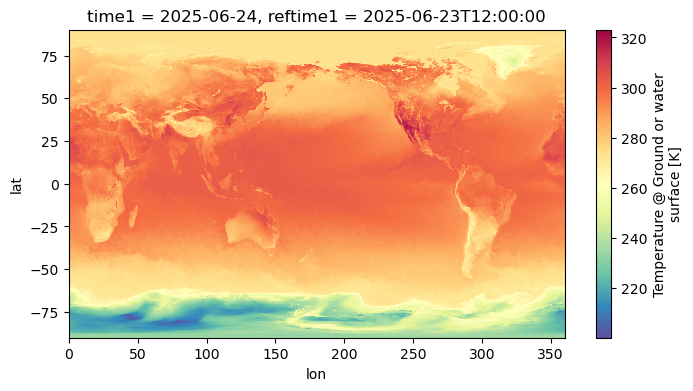

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
ds_subset["Temperature_surface"].sel(time1=fecha, method="nearest").plot(
    cmap="Spectral_r", ax=ax
);

Utilizando [`Cartopy`](https://scitools.org.uk/cartopy/docs/latest/) podemos trabajar con [sistemas coordenados de referencia](https://scitools.org.uk/cartopy/docs/latest/reference/crs.html) (CRS por sus siglas en ingles *Cordinate reference Systems*) y diferentes [proyecciones](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html). Como ejemplo, trabajaremos con un proyección `Mollweide` con centro sobre Colombia (285° en longitud aproximadamente).

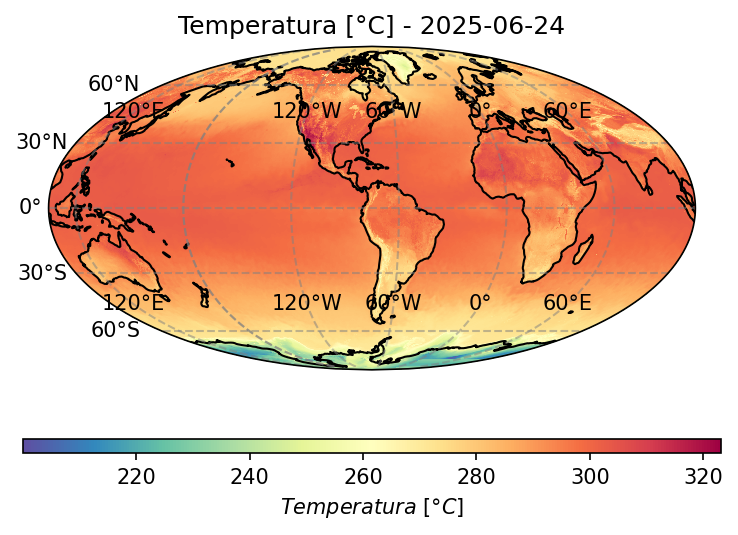

In [13]:
fig, ax = plt.subplots(
    figsize=(6, 4),
    subplot_kw={"projection": ccrs.Mollweide(central_longitude=285)},
    dpi=150,
)

ds_subset["Temperature_surface"].sel(time1=fecha, method="nearest").plot(
    ax=ax,
    cmap="Spectral_r",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        "label": r"$Temperatura \ [°C]$",
        "orientation": "horizontal",
        "aspect": 50,
    },
)
ax.coastlines()
gl = ax.gridlines(
    draw_labels=True, linewidth=1, color="gray", alpha=0.5, linestyle="--"
)
plt.title(f"Temperatura [°C] - {fecha}");

Podemos generar un gráfico para Colombia y sus alrededores de la siguiente manera:

In [14]:
ds_col = ds_subset.sel(lat=slice(20, -10), lon=slice(270, 310))
display(ds_col)

<xarray.Dataset> Size: 56MB
Dimensions:                                (time1: 181, lat: 121, lon: 160,
                                            height_above_ground4: 1)
Coordinates:
  * time1                                  (time1) datetime64[ns] 1kB 2025-06...
    reftime1                               (time1) datetime64[ns] 1kB ...
  * height_above_ground4                   (height_above_ground4) float32 4B 2.0
  * lat                                    (lat) float64 968B 20.0 ... -10.0
  * lon                                    (lon) float64 1kB 270.2 ... 310.0
Data variables:
    Temperature_surface                    (time1, lat, lon) float32 14MB ...
    Pressure_surface                       (time1, lat, lon) float32 14MB ...
    Precipitation_rate_surface             (time1, lat, lon) float32 14MB ...
    Relative_humidity_height_above_ground  (time1, height_above_ground4, lat, lon) float32 14MB ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

De igual modo podemos visualizar los datos usando `contour` y `contourf`. A continuación, podemos observar los gráficos de la temperatura, presión, precipitación y humedad relativa

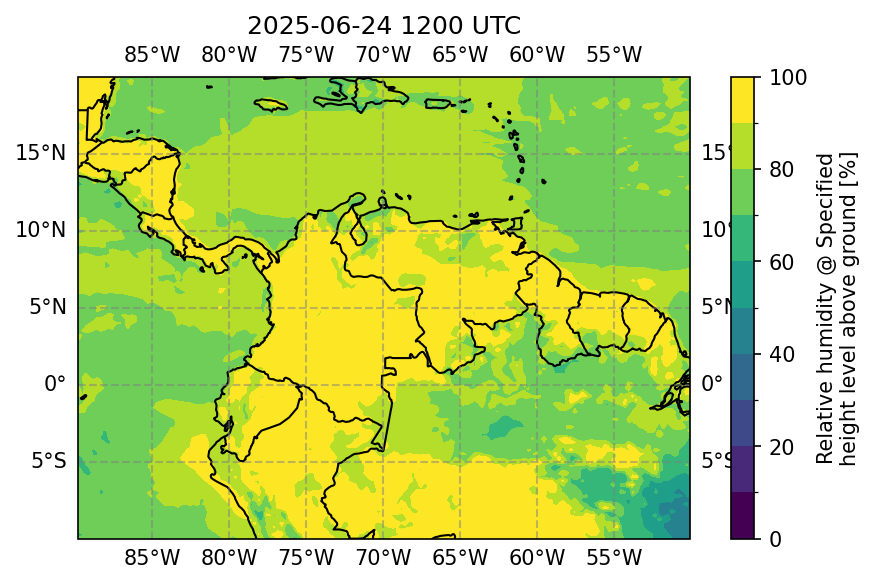

In [15]:
# Creación del "lienzo"
fig, ax = plt.subplots(
    figsize=(7, 4),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=285)},
    dpi=150,
)

# Grafico de variables
# (ds_col.Pressure_surface.sel(time1=f"{fecha} 12:00") / 100).plot.contour(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis_r',
#                                              linewidths=0.5,
#                                             levels=np.arange(500, 1000, 100))
# (ds_col.Temperature_surface.sel(time1=f"{fecha} 12:00") - 273.15).plot.contourf(ax=ax, cmap='Spectral_r', transform=ccrs.PlateCarree(),
#                                          levels=np.arange(0, 35, 1))
ds_col.Relative_humidity_height_above_ground.sel(time1=f"{fecha} 12:00").isel(
    height_above_ground4=0
).plot.contourf(
    ax=ax, cmap="viridis", transform=ccrs.PlateCarree(), levels=np.arange(0, 101, 10)
)

# (ds_col.Precipitation_rate_surface.sel(time=f"{fecha} 12:00") * 86400).plot.contourf(ax=ax,
#                                                           transform=ccrs.PlateCarree(),
#                                                           levels=np.arange(0, 50, 1))

# Adicionamos lineas costeras y división entre países
ax.coastlines()
ax.add_feature(cf.BORDERS)

# Agregar las líneas de reticula
gl = ax.gridlines(
    draw_labels=True, linewidth=1, color="gray", alpha=0.5, linestyle="--"
)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title(
    f"{to_datetime(ds_col.sel(time1=f'{fecha} 12:00').time1.values):%Y-%m-%d %H%M} UTC"
);

Podemos gener series de tiempo con los valores pronosticados para una ubicacion en particular. Utilicemos la ubicación de la Universidad del Quindio como ejemplo: `lat=4.54` y `lon=-75.68`.

In [16]:
ds_uniq = ds_col.sel(lat=4.54, lon=360 - 75.0, method="nearest")
ds_uniq

<xarray.Dataset> Size: 6kB
Dimensions:                                (time1: 181, height_above_ground4: 1)
Coordinates:
  * time1                                  (time1) datetime64[ns] 1kB 2025-06...
    reftime1                               (time1) datetime64[ns] 1kB ...
  * height_above_ground4                   (height_above_ground4) float32 4B 2.0
    lat                                    float64 8B 4.5
    lon                                    float64 8B 284.9
Data variables:
    Temperature_surface                    (time1) float32 724B ...
    Pressure_surface                       (time1) float32 724B ...
    Precipitation_rate_surface             (time1) float32 724B ...
    Relative_humidity_height_above_ground  (time1, height_above_ground4) float32 724B ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

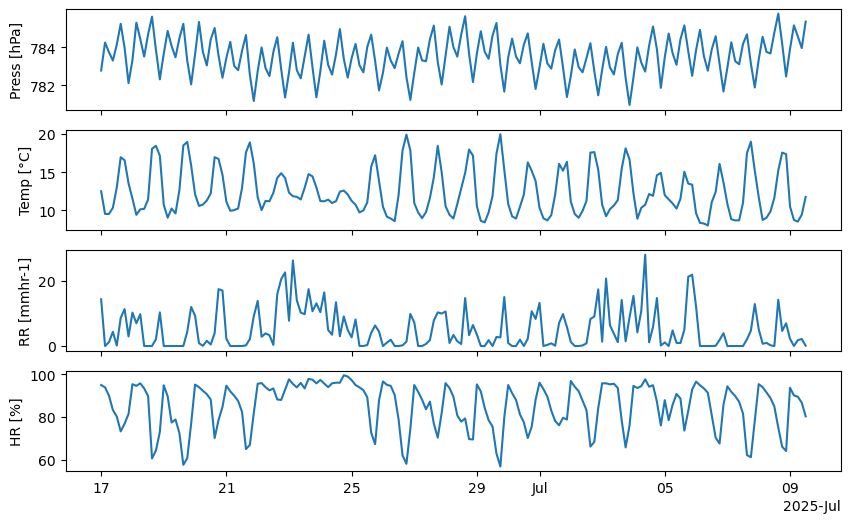

In [17]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
(ds_uniq.Pressure_surface / 100).plot(ax=ax)
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("Press [hPa]")
(ds_uniq.Temperature_surface - 273.15).plot(ax=ax1)
ax1.set_title("")
ax1.set_xlabel("")
ax1.set_ylabel("Temp [°C]")
(ds_uniq.Precipitation_rate_surface * 86400).plot(ax=ax2)
ax2.set_title("")
ax2.set_xlabel("")
ax2.set_ylabel("RR [mmhr-1]")
ds_uniq.Relative_humidity_height_above_ground.isel(height_above_ground4=0).plot(ax=ax3)
ax3.set_title("")
ax3.set_xlabel("")
ax3.set_ylabel("HR [%]");

Otras variables disponibles en el modelo GFS pueden ser gráficadas.

---

## Conclusiones
En este cuadernillo aprendimos a consultar datos provenientes del modelo Global Forecast System usando la librería `Siphon` disponibles en el servidor Thredds de la NCAR. Aprendimos a generar gráficos espaciales y series temporales de pronósticos para múltiples variables usando `Xarray`, `Cartopy` y `Matplotlib`. 

## Resources and references
* [Global Forecast System (GFS)](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast)
* [TDS Online Tutorial](https://docs.unidata.ucar.edu/tds/current/userguide/index.html)